This notebook creates a gif of: 
1. sequential igrams or 
2. cumulative igrams

both with precipitation plot on the side as time progresses. 
<br> precip dates match because it loads precip_2days.txt which I set up to match up with sequential igrams.

This is where I found the info: 
>documentation: https://imageio.readthedocs.io/en/stable/examples.html <br>
>change frame rate: https://stackoverflow.com/questions/38433425/custom-frame-duration-for-animated-gif-in-python-imageio

This notebook was organized on 9-28-22

***

Import things. Use conda environment oliviaJupyter.

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from datetime import datetime
import imageio
%matplotlib  widget

Define working + crop directories, dimensions of SLCs, dates to import (all of them).

In [2]:
workdir = '/data/ocp4/LagunaSalada/'
cropdir = 'cropped_9000_1800_18000_3600/'
#cropdir='cropped_9000_20_10000_1780'

# for loading each slc with correct num of pixels 
# this is for full region
x1=0; y1=0
#dx=10000
dx=18000
#dy=1780
dy=3600

Load dates of SLCs to import. Convert them to datetime objects. 

In [5]:
dates = [os.path.basename(x) for x in glob.glob(workdir+cropdir+"SLC_vv/2*")]
dates=sorted(dates)
nd=len(dates) 
print(str(nd)+' dates') #nd is 211 as of 9-27-22


# make the dates from precip.txt into datetime objects
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))

211 dates


OPTIONAL: Define a zoomed in region for creating a gif. 
<br> If you want to crop, you'll have to change the imshow plotting lines of code in the following two cells. 

In [ ]:
# this is for zoomed in region 
#x1=8000; y1=1100; x2=11000; y2=1800
#dx=x2-x1
#dy=y2-y1

Load precipitation data and convert it to cm. 

In [14]:
# load precip data
precip = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip_2days.txt') # still in inches
# convert to cm from inches 
precip = precip*2.54
# the dates of these are the same as the interferograms. So there are 211 precip dates also. 

Next few cells: Create a single image to use for designing how the gif will be laid out.
<br> <br> Load SLCs and produce single interferogram.

In [8]:
# load slc
i=4 # this tells it which igram to plot as a test 
# load in the two SLCs 
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", \
                gdal.GA_ReadOnly)
slc1 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i+1]+"/"+dates[i+1]+".slc.full", \
                gdal.GA_ReadOnly)
slc2 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
# make igram
int12 = slc1 * np.conj(slc2)

Subtract a mean value from the igram, this is necessary when producing gif that flips through all igrams. Normalizes them so the colors don't vary widely between igrams. 

In [9]:
# subtract a mean value from center of image 
# find center of frame
centerx = int(dx/2)
centery = int(dy/2)
avgDx = 20; avgDy = 4
avgVal = np.mean(int12[centery-avgDy:centery+avgDy,centerx-avgDx:centerx+avgDx])
int12norm = int12*np.conj(avgVal)
#print(centerx,centery,avgVal)

Plot the igram with precip data on the side to edit it before creating gif (which takes a long time).

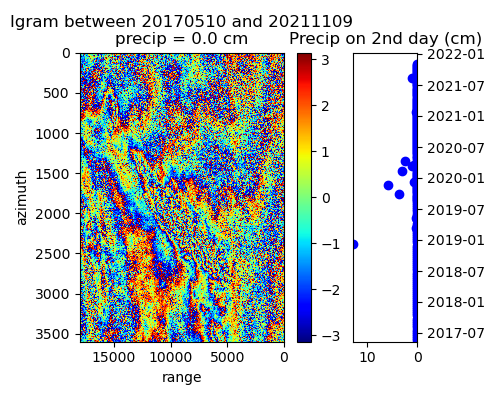

In [12]:
# plot single igram
i=200 # this tells it what igram date to plot precipitation up to
fig = plt.subplots(1,2,figsize=(5, 4),gridspec_kw={'width_ratios': [4, 1]},\
                  tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(np.angle(int12norm),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='auto', \
                interpolation='nearest', extent = [x1,dx,dy,y1])
                # extent is [left,right,bottom,top]
                # except that didn't work/match the correct orientation 
plt.ylabel('azimuth')
plt.xlabel('range')
# reverse axes so it represents/is similar to actual coordinates
plt.xlim([dx,x1])
plt.ylim([dy,y1])
plt.colorbar()
plt.title("Igram between "+str(dates[0])+" and "+str(dates[i+1])+"\n"+ \
             "precip = "+str(round(precip[i],4))+' cm')
    
# plot precipitation for that igram
ax = plt.subplot(1,2,2)
plt.plot(precip[1:i+1],slc_dates[1:i+1],'bo')
plt.ylim([slc_dates[0],slc_dates[-1]])
plt.xlim([np.max(precip),0])  
#plt.xlim([2, 0])
plt.title('Precip on 2nd day (cm)')
ax.yaxis.tick_right()
  
plt.show()

Now: Create a gif with all sequential interferograms. This takes a long time. It then saves each image to put them together as a gif in the next step. 

In [6]:
# Sequential igrams 
filenames = []
for i in np.arange(10,nd-1): # for all igrams, use: np.arange(nd-1)
    # load in the two SLCs 
    ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", \
                   gdal.GA_ReadOnly)
    slc1 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
    ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i+1]+"/"+dates[i+1]+".slc.full", \
                   gdal.GA_ReadOnly)
    slc2 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
    # make igram
    int12 = slc1 * np.conj(slc2)
    
    # subtract a mean value from center of image 
    # find center of frame
    centerx = int(dx/2)
    centery = int(dy/2)
    avgDx = 20; avgDy = 4
    avgVal = np.mean(int12[centery-avgDy:centery+avgDy,centerx-avgDx:centerx+avgDx])
    int12norm = int12*np.conj(avgVal)

    # plot igram
    fig= plt.subplots(1,2,figsize=(10, 8),gridspec_kw={'width_ratios': [4, 1]},\
                  tight_layout=True)
    plt.subplot(1,2,1)
    plt.imshow(np.angle(int12norm),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='auto', \
                interpolation='nearest', extent = [x1,dx,dy,y1])
    plt.ylabel('azimuth')
    plt.xlabel('range')
    plt.xlim([x2,x1])
    plt.ylim([y2,y1])
    plt.colorbar()
    plt.title("Igram between "+str(dates[i])+" and "+str(dates[i+1])+"\n"+ \
             "precip = "+str(round(precip[i],4))+' cm')
    # plot precipitation for that igram
    ax = plt.subplot(1,2,2)
    plt.plot(precip[0:i+1],slc_dates[0:i+1],'bo')
    plt.ylim([slc_dates[0],slc_dates[-1]])
    #plt.xlim([np.max(precip),0])  
    plt.xlim([2,0])
    plt.title('Precip on 2nd date (cm)')
    ax.yaxis.tick_right()
    
    # create file name and append it to a list
    filename = f'igram{i}.png'
    
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close() 

Do the same but with Cumulative Igrams: (all relative to first date)

In [11]:
# Cumulative igrams (all relative to first date)
filenames = []

# load in first SLC that all will be compared to 
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[0]+"/"+dates[0]+".slc.full", \
                   gdal.GA_ReadOnly)
slc1 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)


for i in np.arange(nd-1): # for all igrams, use: np.arange(nd-1)
    # load in the second SLC 
    ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i+1]+"/"+dates[i+1]+".slc.full", \
                   gdal.GA_ReadOnly)
    slc2 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
    # make igram
    int12 = slc1 * np.conj(slc2)
    
    # subtract a mean value from center of image 
    # find center of frame
    centerx = int(dx/2)
    centery = int(dy/2)
    avgDx = 20; avgDy = 4
    avgVal = np.mean(int12[centery-avgDy:centery+avgDy,centerx-avgDx:centerx+avgDx])
    int12norm = int12*np.conj(avgVal)
    
    # plot igram
    fig= plt.subplots(1,2,figsize=(10, 8),gridspec_kw={'width_ratios': [4, 1]},\
                  tight_layout=True)
    plt.subplot(1,2,1)
    plt.imshow(np.angle(int12norm),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='auto', \
                interpolation='nearest', extent = [x1,dx,dy,y1])
    plt.ylabel('azimuth')
    plt.xlabel('range')
    plt.xlim([x2,x1])
    plt.ylim([y2,y1])
    plt.colorbar()
    plt.title("Igram between "+str(dates[0])+" and "+str(dates[i+1])+"\n"+ \
             "precip = "+str(round(precip[i],4))+' cm')
    # plot precipitation for that igram
    ax = plt.subplot(1,2,2)
    plt.plot(precip[0:i+1],slc_dates[0:i+1],'bo')
    plt.ylim([slc_dates[0],slc_dates[-1]])
    #plt.xlim([np.max(precip),0])  
    plt.xlim([2,0])
    plt.title('Precip on 2nd date (cm)')
    ax.yaxis.tick_right()
    
    # create file name and append it to a list
    filename = f'igram{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()

If the whole cell above didn't run, you may have to start the loop at the place where it stopped, run it again, and run the following cell to reconstruct the filenames array to build the gif. 

In [12]:
filenames = []
for i in np.arange(nd-1): # nd-1 for all igrams
    # create file name and append it to a list
    filename = f'igram{i}.png'
    filenames.append(filename)

Put the files together into a gif. 

In [13]:
# build gif
with imageio.get_writer('igramsCum.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.v2.imread(filename)
        writer.append_data(image)

Change the frame rate. The default is too fast. 

In [14]:
# modify the frame duration as needed
images = list(map(lambda filename: imageio.v2.imread(filename), filenames))
imageio.v2.mimsave(os.path.join('igramsCum.gif'), images, duration = 0.5)

Now remove all the individual files that have been made into a gif. So we don't end up with so many files. 

In [15]:
# Remove files
for filename in set(filenames):
    os.remove(filename)